This notebook evalautes the impact that different GSOs and other elements have in the performance of the GCNN_2L with 2 layers. The goal is to identify the key features behind the good performance of these architectures (fixed low-pass filters, degree-normalized adjacency,...)

In [1]:
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import dgl
import networkx as nx
import torch
import torch.nn as nn

import utils
from gsp_utils.baselines_archs import GCNN_2L, GAT
from gsp_utils.baselines_modesl import NodeClassModel
from gsp_utils.data import normalize_gso
from src.arch import GCNN

SEED = 0
PATH = 'results/impact_gso/'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(SEED)

cuda:1


In [2]:
# Common parameters
n_runs = 25
n_epochs = 200
lr = .01
wd = 5e-4
eval_freq = 20

## Get Data

In [3]:
# Dataset must be from DGL
dataset_name = 'CornellDataset'

A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device,
                                                     verb=True)
N = A.shape[0]

Dataset: CornellDataset
Number of nodes: 183
Number of features: 1703
Shape of signals: torch.Size([183, 1703])
Number of classes: 5
Norm of A: 17.262676239013672
Max value of A: 1.0
Proportion of validation data: 0.32
Proportion of test data: 0.20
Node homophily: 0.11
Edge homophily: 0.13


## Influence of different normalizations

### Normalizing A+I

In [4]:
# GCNN_2L
in_dim = feat.shape[1]
out_dim = n_class
hid_dim = 16
dropout = .5
bias = True
Norms = ['none', 'right', 'left', 'both', 'eigen'] 
act = nn.ReLU()
last_act = nn.LogSoftmax(dim=1)  # nn.Identity() # nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()  # nn.CrossEntropyLoss() # nn.NLLLoss()

In [5]:
best_acc = np.zeros((len(Norms), n_runs))
for i in range(n_runs):
    print(f'- Run {i+1}: ', end=' ')
    losses = []
    accs = []
    for j, norm in enumerate(Norms):

        if norm == 'eigen':
            norm = 'none'
            A_sel = A/np.linalg.norm(A + np.eye(A.shape[0]), 2)
        else:
            A_sel = A

        arch = GCNN_2L(in_dim, hid_dim, out_dim, act=act, last_act=last_act, bias=bias,
                    norm=norm, dropout=dropout)
        
        A_dgl = dgl.from_networkx(nx.from_numpy_array(A_sel)).add_self_loop().to(device)
        model = NodeClassModel(arch, A_dgl, masks, loss=loss_fn, device=device)
        loss, acc = model.train(feat, labels, n_epochs, lr, wd, eval_freq=eval_freq,
                                verb=False)

        losses.append(loss)
        accs.append(acc)
        best_acc[j,i] = np.max(acc["test"])

        print(f'{norm}: {np.max(acc["test"]):.3f}', end=' - ')
    print()


- Run 1:  none: 0.405 - right: 0.486 - left: 0.541 - both: 0.541 - none: 0.405 - 
- Run 2:  none: 0.514 - right: 0.486 - left: 0.486 - both: 0.568 - none: 0.432 - 
- Run 3:  none: 0.405 - right: 0.514 - left: 0.514 - both: 0.568 - none: 0.405 - 
- Run 4:  none: 0.405 - right: 0.514 - left: 0.514 - both: 0.514 - none: 0.405 - 
- Run 5:  none: 0.432 - right: 0.541 - left: 0.514 - both: 0.486 - none: 0.405 - 
- Run 6:  none: 0.486 - right: 0.568 - left: 0.514 - both: 0.514 - none: 0.432 - 
- Run 7:  none: 0.432 - right: 0.541 - left: 0.514 - both: 0.514 - none: 0.405 - 
- Run 8:  none: 0.541 - right: 0.514 - left: 0.486 - both: 0.541 - none: 0.432 - 
- Run 9:  none: 0.432 - right: 0.514 - left: 0.486 - both: 0.514 - none: 0.405 - 
- Run 10:  none: 0.486 - right: 0.514 - left: 0.514 - both: 0.514 - none: 0.541 - 
- Run 11:  none: 0.568 - right: 0.541 - left: 0.514 - both: 0.514 - none: 0.514 - 
- Run 12:  none: 0.486 - right: 0.514 - left: 0.486 - both: 0.486 - none: 0.459 - 
- Run 13:  no

In [6]:
# Print results
mean_accs = np.mean(best_acc, axis=1)
std_accs = np.std(best_acc, axis=1)
for i, norm in enumerate(Norms):
    print(f'- Norm: {norm}:  Acc: {mean_accs[i]:.3f}  Std: {std_accs[i]:.4f}')

- Norm: none:  Acc: 0.466  Std: 0.0497
- Norm: right:  Acc: 0.511  Std: 0.0253
- Norm: left:  Acc: 0.507  Std: 0.0158
- Norm: both:  Acc: 0.520  Std: 0.0245
- Norm: eigen:  Acc: 0.436  Std: 0.0428


Text(0.5, 1.0, 'Acc - eigen')

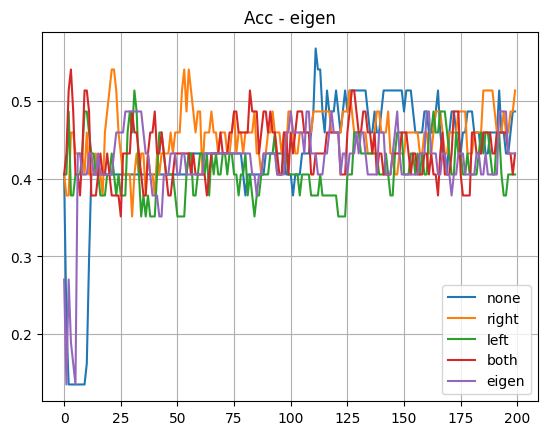

In [7]:
plt.figure()
for i, norm in enumerate(Norms):
    plt.plot(accs[i]['test'], label=norm)

plt.legend()
plt.grid()
plt.title('Acc - '+ norm)


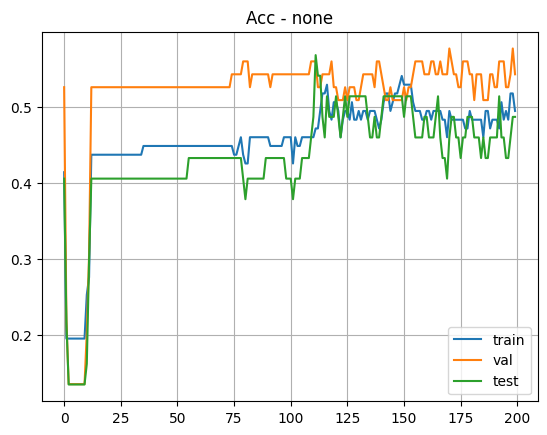

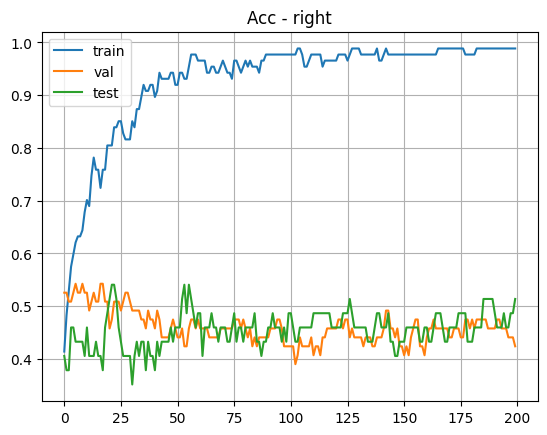

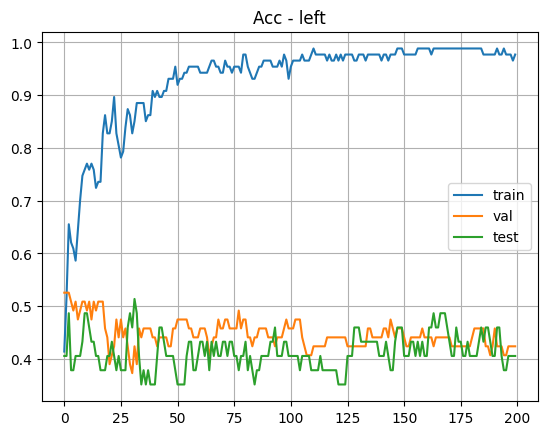

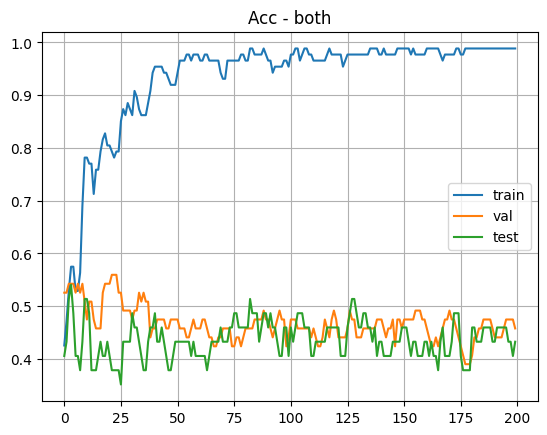

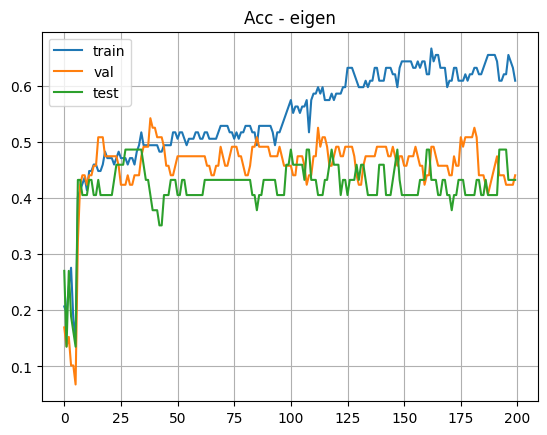

In [8]:
for i, norm in enumerate(Norms):
    plt.figure()
    plt.plot(accs[i]['train'], label='train')
    plt.plot(accs[i]['val'], label='val')
    plt.plot(accs[i]['test'], label='test')
    plt.legend()
    plt.grid()
    plt.title('Acc - '+ norm)

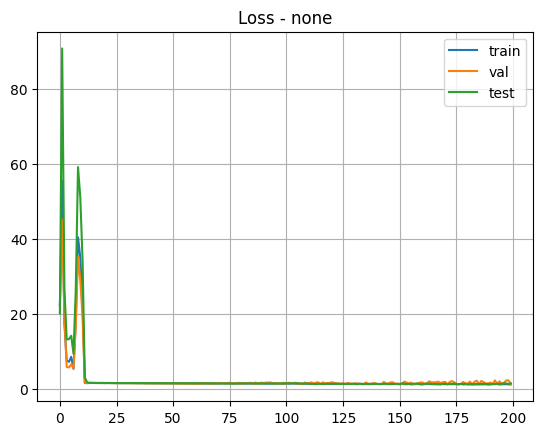

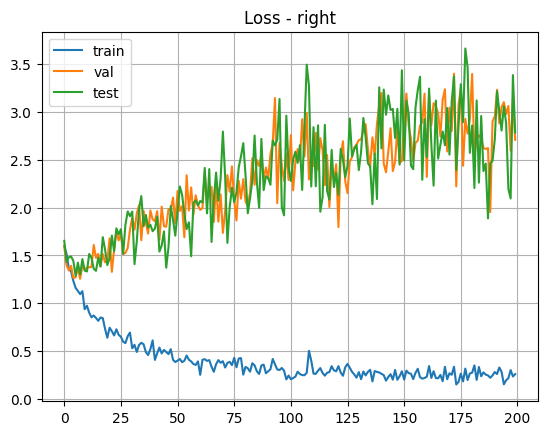

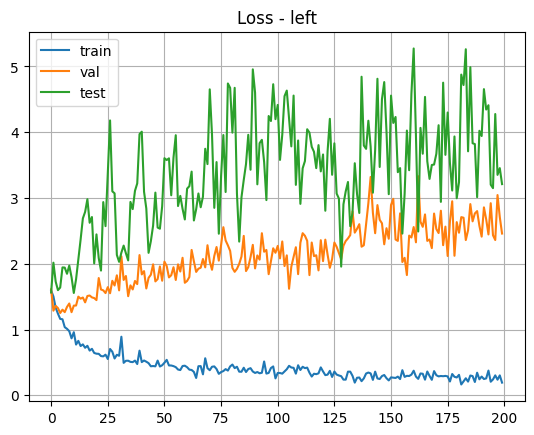

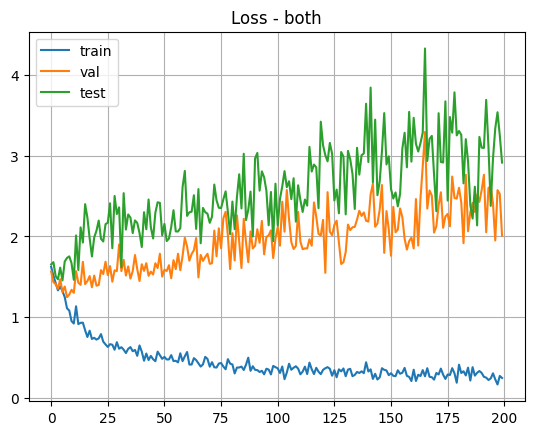

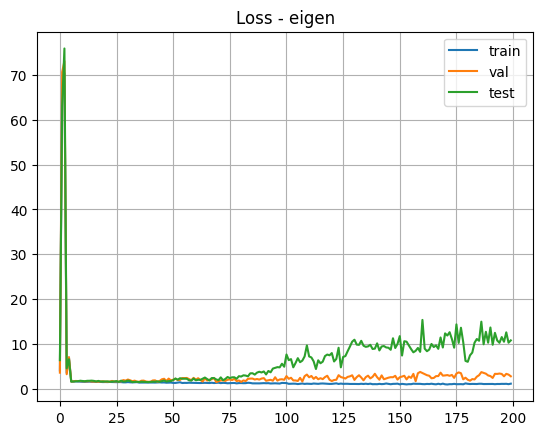

In [9]:
for i, norm in enumerate(Norms):
    plt.figure()
    plt.plot(losses[i]['train'], label='train')
    plt.plot(losses[i]['val'], label='val')
    plt.plot(losses[i]['test'], label='test')
    plt.legend()
    plt.grid()
    plt.title('Loss - '+ norm)

### Normalizing A

In [10]:
# GNN params
in_dim = feat.shape[1]
out_dim = n_class
hid_dim = 16
n_layers = 2
dropout = .5
bias = True
Norms = ['classical', 'right', 'left', 'both', 'eigen'] 
act = nn.ReLU()
last_act = nn.LogSoftmax(dim=1)  # nn.Identity() # nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()  # nn.CrossEntropyLoss() # nn.NLLLoss()

In [11]:
best_acc = np.zeros((len(Norms), n_runs))
for i in range(n_runs):
    print(f'- Run {i+1}: ', end=' ')
    losses = []
    accs = []
    for j, norm in enumerate(Norms):

        if norm == 'classical':
            A_norm = normalize_gso(A + np.eye(N), 'both')
        else:
            A_norm = normalize_gso(A, norm) + np.eye(N)

        A_norm = torch.Tensor(A_norm).to(device)

        # A_norm = A_norm.to_sparse()
        arch = GCNN(in_dim, hid_dim, out_dim, n_layers, act=act, last_act=last_act, bias=bias,
                    dropout=dropout)
        
        model = NodeClassModel(arch, A_norm, masks, loss=loss_fn, device=device)
        loss, acc = model.train(feat, labels, n_epochs, lr, wd, eval_freq=eval_freq,
                                verb=False)

        losses.append(loss)
        accs.append(acc)
        best_acc[j,i] = np.max(acc["test"])

        print(f'{norm}: {np.max(acc["test"]):.3f}', end=' - ')
    print()


- Run 1:  classical: 0.486 - 

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:43: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(1/S.sum(1))
/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:46: RuntimeWarning: invalid value encountered in matmul
  return S @ D_inv


right: 0.270 - 

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:48: RuntimeWarning: invalid value encountered in matmul
  return D_inv @ S


left: 0.270 - 

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:51: RuntimeWarning: invalid value encountered in matmul
  return D_inv_sqr @ S @ D_inv_sqr


both: 0.270 - eigen: 0.541 - 
- Run 2:  classical: 0.459 - right: 0.270 - left: 0.270 - both: 0.270 - eigen: 0.514 - 
- Run 3:  classical: 0.459 - right: 0.270 - left: 0.270 - both: 0.270 - eigen: 0.514 - 
- Run 4:  classical: 0.486 - right: 0.270 - left: 0.270 - both: 0.270 - eigen: 0.568 - 
- Run 5:  classical: 0.514 - right: 0.270 - left: 0.270 - both: 0.270 - eigen: 0.595 - 
- Run 6:  classical: 0.459 - right: 0.270 - left: 0.270 - both: 0.270 - eigen: 0.514 - 
- Run 7:  classical: 0.486 - right: 0.270 - left: 0.270 - both: 0.270 - eigen: 0.541 - 
- Run 8:  classical: 0.459 - right: 0.270 - left: 0.270 - both: 0.270 - eigen: 0.541 - 
- Run 9:  classical: 0.459 - right: 0.270 - left: 0.270 - both: 0.270 - eigen: 0.514 - 
- Run 10:  classical: 0.459 - right: 0.270 - left: 0.270 - both: 0.270 - eigen: 0.541 - 
- Run 11:  classical: 0.459 - right: 0.270 - left: 0.270 - both: 0.270 - eigen: 0.595 - 
- Run 12:  classical: 0.432 - right: 0.270 - left: 0.270 - both: 0.270 - eigen: 0.514 - 

- Norm: classical:  Acc: 0.457  Std: 0.0275
- Norm: right:  Acc: 0.270  Std: 0.0000
- Norm: left:  Acc: 0.270  Std: 0.0000
- Norm: both:  Acc: 0.270  Std: 0.0000
- Norm: eigen:  Acc: 0.550  Std: 0.0349


Text(0.5, 1.0, 'Acc - eigen')

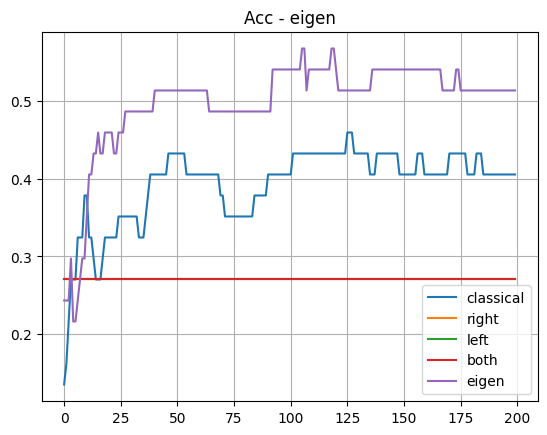

In [12]:
# Print results
mean_accs = np.mean(best_acc, axis=1)
std_accs = np.std(best_acc, axis=1)
for i, norm in enumerate(Norms):
    print(f'- Norm: {norm}:  Acc: {mean_accs[i]:.3f}  Std: {std_accs[i]:.4f}')

plt.figure()
for i, norm in enumerate(Norms):
    plt.plot(accs[i]['test'], label=norm)

plt.legend()
plt.grid()
plt.title('Acc - '+ norm)

## Dropout

In [13]:
# GCNN_2L
in_dim = feat.shape[1]
out_dim = n_class
hid_dim = 16
DROPOUTS = [0, .25, .5, .75, .9]
bias = True
norm = 'both' 
act = nn.ReLU()
last_act = nn.LogSoftmax(dim=1)  # nn.Identity() # nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()  # nn.CrossEntropyLoss() # nn.NLLLoss()

In [14]:
best_acc = np.zeros((len(DROPOUTS), n_runs))
for i in range(n_runs):
    print(f'- Run {i+1}: ', end=' ')
    losses = []
    accs = []
    for j, drops in enumerate(DROPOUTS):
        arch = GCNN_2L(in_dim, hid_dim, out_dim, act=act, last_act=last_act, bias=bias,
                    norm=norm, dropout=drops)
        
        A_dgl = dgl.from_networkx(nx.from_numpy_array(A)).add_self_loop().to(device)
        model = NodeClassModel(arch, A_dgl, masks, loss=loss_fn, device=device)
        loss, acc = model.train(feat, labels, n_epochs, lr, wd, eval_freq=eval_freq,
                                verb=False)

        losses.append(loss)
        accs.append(acc)
        best_acc[j,i] = np.max(acc["test"])

        print(f'{drops}: {np.max(acc["test"]):.3f}', end=' - ')
    print()


- Run 1:  0: 0.514 - 0.25: 0.568 - 0.5: 0.568 - 0.75: 0.514 - 0.9: 0.541 - 
- Run 2:  0: 0.514 - 0.25: 0.541 - 0.5: 0.514 - 0.75: 0.514 - 0.9: 0.514 - 
- Run 3:  0: 0.514 - 0.25: 0.514 - 0.5: 0.514 - 0.75: 0.486 - 0.9: 0.541 - 
- Run 4:  0: 0.541 - 0.25: 0.541 - 0.5: 0.514 - 0.75: 0.459 - 0.9: 0.432 - 
- Run 5:  0: 0.514 - 0.25: 0.541 - 0.5: 0.486 - 0.75: 0.541 - 0.9: 0.486 - 
- Run 6:  0: 0.541 - 0.25: 0.541 - 0.5: 0.514 - 0.75: 0.595 - 0.9: 0.432 - 
- Run 7:  0: 0.514 - 0.25: 0.541 - 0.5: 0.486 - 0.75: 0.514 - 0.9: 0.486 - 
- Run 8:  0: 0.514 - 0.25: 0.514 - 0.5: 0.514 - 0.75: 0.514 - 0.9: 0.459 - 
- Run 9:  0: 0.514 - 0.25: 0.514 - 0.5: 0.514 - 0.75: 0.486 - 0.9: 0.486 - 
- Run 10:  0: 0.541 - 0.25: 0.541 - 0.5: 0.514 - 0.75: 0.514 - 0.9: 0.514 - 
- Run 11:  0: 0.541 - 0.25: 0.514 - 0.5: 0.514 - 0.75: 0.514 - 0.9: 0.486 - 
- Run 12:  0: 0.514 - 0.25: 0.541 - 0.5: 0.514 - 0.75: 0.514 - 0.9: 0.459 - 
- Run 13:  0: 0.541 - 0.25: 0.514 - 0.5: 0.595 - 0.75: 0.459 - 0.9: 0.514 - 
- Run 14

In [15]:
# Print results
mean_accs = np.mean(best_acc, axis=1)
std_accs = np.std(best_acc, axis=1)
for i, drops in enumerate(DROPOUTS):
    print(f'- Dropout: {drops}:  Acc: {mean_accs[i]:.3f}  Std: {std_accs[i]:.4f}')

- Dropout: 0:  Acc: 0.529  Std: 0.0172
- Dropout: 0.25:  Acc: 0.537  Std: 0.0176
- Dropout: 0.5:  Acc: 0.518  Std: 0.0261
- Dropout: 0.75:  Acc: 0.503  Std: 0.0296
- Dropout: 0.9:  Acc: 0.492  Std: 0.0405


Text(0.5, 1.0, 'Dropout')

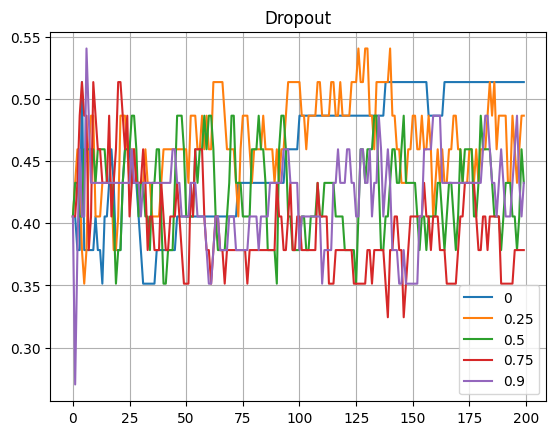

In [16]:
plt.figure()
for i, drops in enumerate(DROPOUTS):
    plt.plot(accs[i]['test'], label=str(drops))

plt.legend()
plt.grid()
plt.title('Dropout')


## Bias + Feat norm

In [17]:
# GCNN_2L
in_dim = feat.shape[1]
out_dim = n_class
hid_dim = 16
dropout = .5
norm = 'both' 
act = nn.ReLU()
last_act = nn.LogSoftmax(dim=1)  # nn.Identity() # nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()  # nn.CrossEntropyLoss() # nn.NLLLoss()

EXPS = [{'bias': True, 'feat_norm': True},
        {'bias': True, 'feat_norm': False},
        {'bias': False, 'feat_norm': True},
        {'bias': False, 'feat_norm': False}]

In [18]:
# feat = utils.normalize_feats(feat)

best_acc = np.zeros((len(Norms), n_runs))
for i in range(n_runs):
    print(f'- Run {i+1}: ', end=' ')
    losses = []
    accs = []
    for j, exp in enumerate(EXPS):

        bias = exp['bias']
        X = utils.normalize_feats(feat) if exp['feat_norm'] else feat

        arch = GCNN_2L(in_dim, hid_dim, out_dim, act=act, last_act=last_act, bias=bias,
                    norm=norm, dropout=dropout)
        
        A_dgl = dgl.from_networkx(nx.from_numpy_array(A)).add_self_loop().to(device)
        model = NodeClassModel(arch, A_dgl, masks, loss=loss_fn, device=device)
        loss, acc = model.train(X, labels, n_epochs, lr, wd, eval_freq=eval_freq,
                                verb=False)

        losses.append(loss)
        accs.append(acc)
        best_acc[j,i] = np.max(acc["test"])

        print(f'{exp["bias"]}-{exp["feat_norm"]}: {np.max(acc["test"]):.3f}', end=' - ')
    print()


- Run 1:  True-True: 0.486 - True-False: 0.568 - False-True: 0.459 - False-False: 0.514 - 
- Run 2:  True-True: 0.486 - True-False: 0.486 - False-True: 0.486 - False-False: 0.541 - 
- Run 3:  True-True: 0.459 - True-False: 0.514 - False-True: 0.486 - False-False: 0.486 - 
- Run 4:  True-True: 0.432 - True-False: 0.459 - False-True: 0.459 - False-False: 0.514 - 
- Run 5:  True-True: 0.514 - True-False: 0.541 - False-True: 0.459 - False-False: 0.541 - 
- Run 6:  True-True: 0.432 - True-False: 0.486 - False-True: 0.459 - False-False: 0.486 - 
- Run 7:  True-True: 0.432 - True-False: 0.568 - False-True: 0.459 - False-False: 0.514 - 
- Run 8:  True-True: 0.432 - True-False: 0.514 - False-True: 0.459 - False-False: 0.514 - 
- Run 9:  True-True: 0.432 - True-False: 0.459 - False-True: 0.459 - False-False: 0.541 - 
- Run 10:  True-True: 0.459 - True-False: 0.514 - False-True: 0.486 - False-False: 0.568 - 
- Run 11:  True-True: 0.459 - True-False: 0.514 - False-True: 0.459 - False-False: 0.541 

- Bias True - Norm feats True:  Acc: 0.457  Std: 0.0314
- Bias True - Norm feats False:  Acc: 0.515  Std: 0.0291
- Bias False - Norm feats True:  Acc: 0.475  Std: 0.0134
- Bias False - Norm feats False:  Acc: 0.515  Std: 0.0247


Text(0.5, 1.0, 'Acc - both')

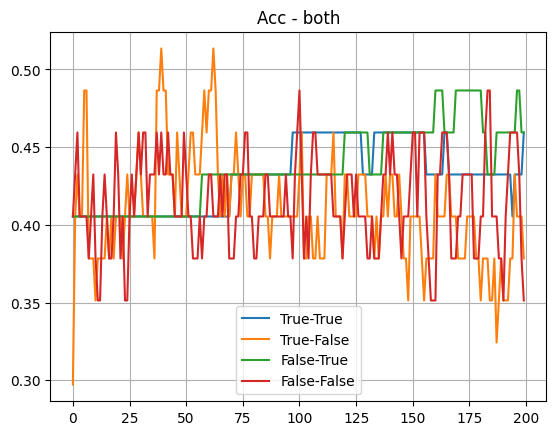

In [19]:
# Print results
mean_accs = np.mean(best_acc, axis=1)
std_accs = np.std(best_acc, axis=1)
for i, exp in enumerate(EXPS):
    print(f'- Bias {exp["bias"]} - Norm feats {exp["feat_norm"]}:  Acc: {mean_accs[i]:.3f}  Std: {std_accs[i]:.4f}')

plt.figure()
for i, exp in enumerate(EXPS):
    plt.plot(accs[i]['test'], label=f'{exp["bias"]}-{exp["feat_norm"]}')

plt.legend()
plt.grid()
plt.title('Acc - '+ norm)

## Activation and loss functions

In [20]:
# GCNN_2L
in_dim = feat.shape[1]
out_dim = n_class
hid_dim = 16
dropout = 0
norm = 'both' 
bias = True

EXPS = [{'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.ReLU(), 'lact': nn.Softmax(), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.Identity(), 'lact': nn.Identity(), 'loss': nn.CrossEntropyLoss()},]

In [21]:
best_acc = np.zeros((len(Norms), n_runs))
for i in range(n_runs):
    print(f'- Run {i+1}: ', end=' ')
    losses = []
    accs = []
    for j, exp in enumerate(EXPS):
        arch = GCNN_2L(in_dim, hid_dim, out_dim, act=exp['act'], last_act=exp['lact'],
                    bias=bias, norm=norm, dropout=dropout)
        
        A_dgl = dgl.from_networkx(nx.from_numpy_array(A)).add_self_loop().to(device)
        model = NodeClassModel(arch, A_dgl, masks, loss=exp['loss'], device=device)
        loss, acc = model.train(feat, labels, n_epochs, lr, wd, eval_freq=eval_freq,
                                verb=False)

        losses.append(loss)
        accs.append(acc)
        best_acc[j,i] = np.max(acc["test"])

        print(f'{j}: {np.max(acc["test"]):.3f}', end=' - ')
    print()


- Run 1:  0: 0.541 - 

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/baselines_archs.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.last_act(h)


1: 0.568 - 2: 0.541 - 3: 0.514 - 
- Run 2:  0: 0.568 - 1: 0.568 - 2: 0.541 - 3: 0.514 - 
- Run 3:  0: 0.541 - 1: 0.622 - 2: 0.541 - 3: 0.514 - 
- Run 4:  0: 0.622 - 1: 0.622 - 2: 0.514 - 3: 0.541 - 
- Run 5:  0: 0.568 - 1: 0.622 - 2: 0.514 - 3: 0.541 - 
- Run 6:  0: 0.541 - 1: 0.568 - 2: 0.514 - 3: 0.514 - 
- Run 7:  0: 0.514 - 1: 0.541 - 2: 0.514 - 3: 0.541 - 
- Run 8:  0: 0.541 - 1: 0.568 - 2: 0.514 - 3: 0.514 - 
- Run 9:  0: 0.514 - 1: 0.595 - 2: 0.541 - 3: 0.514 - 
- Run 10:  0: 0.595 - 1: 0.595 - 2: 0.514 - 3: 0.514 - 
- Run 11:  0: 0.541 - 1: 0.568 - 2: 0.568 - 3: 0.541 - 
- Run 12:  0: 0.514 - 1: 0.622 - 2: 0.568 - 3: 0.541 - 
- Run 13:  0: 0.568 - 1: 0.622 - 2: 0.514 - 3: 0.514 - 
- Run 14:  0: 0.514 - 1: 0.595 - 2: 0.541 - 3: 0.514 - 
- Run 15:  0: 0.568 - 1: 0.568 - 2: 0.568 - 3: 0.514 - 
- Run 16:  0: 0.514 - 1: 0.622 - 2: 0.541 - 3: 0.514 - 
- Run 17:  0: 0.514 - 1: 0.622 - 2: 0.568 - 3: 0.514 - 
- Run 18:  0: 0.514 - 1: 0.595 - 2: 0.541 - 3: 0.541 - 
- Run 19:  0: 0.541 - 

- 0:  Acc: 0.539  Std: 0.0281
- 1:  Acc: 0.600  Std: 0.0350
- 2:  Acc: 0.535  Std: 0.0202
- 3:  Acc: 0.521  Std: 0.0143


Text(0.5, 1.0, 'Acc - both')

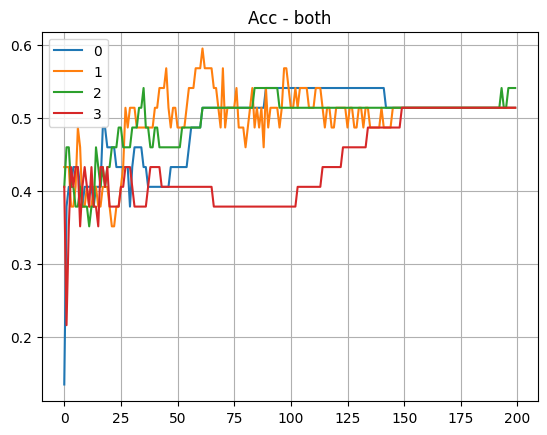

In [22]:
# Print results
mean_accs = np.mean(best_acc, axis=1)
std_accs = np.std(best_acc, axis=1)
for i, exps in enumerate(EXPS):
    print(f'- {i}:  Acc: {mean_accs[i]:.3f}  Std: {std_accs[i]:.4f}')

plt.figure()
for i, exp in enumerate(EXPS):
    plt.plot(accs[i]['test'], label=f'{i}')

plt.legend()
plt.grid()
plt.title('Acc - ' + norm)